# Performing Large Numbers of Calculations with Thermo in Parallel

A common request is to obtain a large number of properties from Thermo at once. Thermo is not NumPy - it cannot just automatically do all of the calculations in parallel. 

If you have a specific property that does not require phase equilibrium calculations to obtain, it is possible to
use the `chemicals.numba` interface to in your own numba-accelerated code.
https://chemicals.readthedocs.io/chemicals.numba.html

For those cases where lots of flashes are needed, your best bet is to brute force it - use multiprocessing (and maybe a beefy machine) to obtain the results faster. The following code sample uses `joblib` to facilitate the calculation. Note that joblib won't show any benefits on sub-second calculations. Also note that the `threading` backend of joblib will not offer any performance improvements due to the CPython GIL.

In [1]:
import numpy as np
from thermo import *
from chemicals import *

constants, properties = ChemicalConstantsPackage.from_IDs(
    ['methane', 'ethane', 'propane', 'isobutane', 'n-butane', 'isopentane', 
     'n-pentane', 'hexane', 'heptane', 'octane', 'nonane', 'nitrogen'])
T, P = 200, 5e6
zs = [.8, .08, .032, .00963, .0035, .0034, .0003, .0007, .0004, .00005, .00002, .07]
eos_kwargs = dict(Tcs=constants.Tcs, Pcs=constants.Pcs, omegas=constants.omegas)
gas = CEOSGas(SRKMIX, eos_kwargs, HeatCapacityGases=properties.HeatCapacityGases, T=T, P=P, zs=zs)
liq = CEOSLiquid(SRKMIX, eos_kwargs, HeatCapacityGases=properties.HeatCapacityGases, T=T, P=P, zs=zs)
# Set up a two-phase flash engine, ignoring kijs
flasher = FlashVL(constants, properties, liquid=liq, gas=gas)

# Set a composition - it could be modified in the inner loop as well
# Do a test flash
flasher.flash(T=T, P=P, zs=zs).gas_beta

0.4595970727935113

In [2]:
def get_properties(T, P):
    # This is the function that will be called in parallel
    # note that Python floats are faster than numpy floats
    res = flasher.flash(T=float(T), P=float(P), zs=zs)
    return [res.rho_mass(), res.Cp_mass(), res.gas_beta]

In [3]:
from joblib import Parallel, delayed
pts = 30
Ts = np.linspace(200, 400, pts)
Ps = np.linspace(1e5, 1e7, pts)
Ts_grid, Ps_grid = np.meshgrid(Ts, Ps)
# processed_data = Parallel(n_jobs=16)(delayed(get_properties)(T, P) for T, P in zip(Ts_grid.flat, Ps_grid.flat))

In [4]:
# Naive loop in Python
%timeit -r 1 -n 1 processed_data = [get_properties(T, P) for T, P in zip(Ts_grid.flat, Ps_grid.flat)]

15.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [5]:
# Use the threading feature of Joblib
# Because the calculation is CPU-bound, the threads do not improve speed and Joblib's overhead slows down the calculation
%timeit -r 1 -n 1 processed_data = Parallel(n_jobs=16, prefer="threads")(delayed(get_properties)(T, P) for T, P in zip(Ts_grid.flat, Ps_grid.flat))

43.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [7]:
# Use the multiprocessing feature of joblib
# We were able to improve the speed by 5x
%timeit -r 1 -n 1 processed_data = Parallel(n_jobs=16, batch_size=30)(delayed(get_properties)(T, P) for T, P in zip(Ts_grid.flat, Ps_grid.flat))

3.55 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [8]:
# For small multiprocessing jobs, the slowest job can cause a significant delay
# For longer and larger jobs the full benefit of using all cores is shown better.
%timeit -r 1 -n 1 processed_data = Parallel(n_jobs=8, batch_size=30)(delayed(get_properties)(T, P) for T, P in zip(Ts_grid.flat, Ps_grid.flat))

4.42 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [9]:
# Joblib returns the data as a flat structure, but we can re-construct it into a grid
processed_data = Parallel(n_jobs=16, batch_size=30)(delayed(get_properties)(T, P) for T, P in zip(Ts_grid.flat, Ps_grid.flat))
phase_fractions = np.array([[processed_data[j*pts+i][2] for j in range(pts)] for i in range(pts)])

<ipython-input-10-719d0a113f9b>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(Ts_grid, Ps_grid, phase_fractions.T, cmap=color_map)


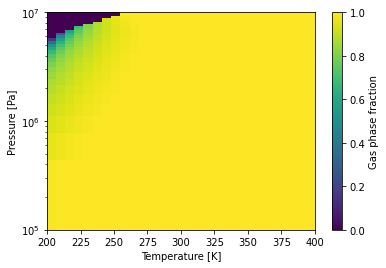

In [10]:
# Make a plot to show the results

import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from matplotlib.colors import LogNorm
fig, ax = plt.subplots()
color_map = cm.viridis
im = ax.pcolormesh(Ts_grid, Ps_grid, phase_fractions.T, cmap=color_map)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Gas phase fraction')

ax.set_yscale('log')
ax.set_xlabel('Temperature [K]')
ax.set_ylabel('Pressure [Pa]')
plt.show()